In [1]:
import jax
from jax import numpy as jnp, random
from variable import *
import jax.lax as lax
from sampler import *
from residual import *
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
from functools import partial
from utils import *
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax.nn import sigmoid

In [2]:
class PINN(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, key=None, width=16, depth=4):
        self.net = eqx.nn.MLP(
            in_size=2, out_size=2, width_size=width, depth=depth,
            activation=jax.nn.tanh, key=key
        )

    def _forward_single(self, x, t):
        inp = jnp.stack([x, t], axis=-1)   # shape (2,)
        out = self.net(inp)                # NO vmap here!
        out_phi = out[...,0]
        out_c = out[...,1]
        # out_phi = sigmoid(out[...,0])
        # out_c = sigmoid(out[...,1])
        # out_phi = 0.5 * (jnp.tanh(out[..., 0]) + 1.0)
        # out_c   = 0.5 * (jnp.tanh(out[..., 1]) + 1.0)
        return out_phi, out_c

    def __call__(self, x, t):
        # handle both scalar and batched inputs smartly:
        if x.ndim == 0:
            return self._forward_single(x, t)   # scalar case
        else:
            # batch case: vmap _forward_single over leading axis
            return jax.vmap(self._forward_single)(x, t)

In [3]:
# Initialize model, sampler, residual, weight, optimizer
key = random.PRNGKey(1312)
key, subkey = random.split(key)

# -- Setup hyper parameters--

s0 = 50000              # Total training steps
sp1 = 100               # Resampling frequency
sp2 = 100              # NTK weighting frequency
sp3 = 500
noise = 1

# sample sizes for traning and NTK weight computation
size = SimpleNamespace(ic=64, bc=64, colloc_x=32, colloc_t=32, adapt=512)
size_rand = SimpleNamespace(ic=32, bc=32, colloc=256, adapt=256)

# define the model, sampler, residual, initialize the weights
model = PINN(key=subkey, width=16, depth=4)
s = Sampler(x_span, t_span, size, size_rand, noise)
r = Residual()
weight = jnp.array([1.0, 1.0, 1.0, 1.0])

# initialize the optimizer
optimizer = optax.adam(1e-4)
params, static = eqx.partition(model, eqx.is_inexact_array)
opt_state = optimizer.init(params)

# initialize the samples and criterion for adaptive sampling
which_criterion = "grad"
x, t = s.get_sample(key, model, which_criterion)

# initialize the initial carry
init = (0, key, x, t, weight, params, opt_state)

In [4]:
def train_step(carry, _):
    step, key, x, t, weight, params, opt_state = carry
    key, subkey1, subkey2 = random.split(key, 3)

    model_temp = eqx.combine(params, static)

    # Conditionally resample points
    x, t = lax.cond(
        step % sp1 == 0,
        lambda _: s.get_sample(subkey1, model_temp, which_criterion),
        lambda _: (x, t),
        operand=None,
    )

    # Conditionally recompute weights
    def update_weight(key, model, x, t):
        x_rand, t_rand = s.get_subsample(key, x, t)
        return r.compute_ntk_weights(model, x_rand, t_rand)

    weight = lax.cond(
        step % sp2 == 0,
        lambda _: update_weight(subkey2, model_temp, x, t),
        lambda _: weight,
        operand=None,
    )

    # Logging function
    def log_fn(step, weight, loss):
        total_loss = jnp.dot(weight, loss)
        jax.debug.print("Step {step}: total_loss = {total:.4e}", step=step, total=total_loss)
        jax.debug.print("  Loss     [AC, CH, IC, BC] = [{:.4e}, {:.4e}, {:.4e}, {:.4e}]",
                        loss[0], loss[1], loss[2], loss[3])
        jax.debug.print("  Weights  [AC, CH, IC, BC] = [{:.4e}, {:.4e}, {:.4e}, {:.4e}]",
                        weight[0], weight[1], weight[2], weight[3])

    # Loss function
    def loss_fn(params, static, x, t, weight, do_log):
        model_full = eqx.combine(params, static)
        l1,l2,l3,l4 = jnp.asarray(r.compute_loss(model_full, x, t))
        losses = jnp.array([l1, 100*l2, l3, l4])
        lax.cond(do_log, lambda _: log_fn(step, weight, losses), lambda _: None, operand=None)
        return jnp.dot(weight, losses)

    do_log = (step % sp3 == 0)
    loss, grads = jax.value_and_grad(loss_fn)(params, static, x, t, weight, do_log)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return (step + 1, key, x, t, weight, params, opt_state), loss

In [5]:
# -- Run Training Loop --
final_carry, loss_history = lax.scan(train_step,init,xs=None,length=s0 + 1)

Step 0: total_loss = 4.1158e+00
  Loss     [AC, CH, IC, BC] = [4.7452e-08, 5.1308e-04, 5.7447e-01, 5.8602e-01]
  Weights  [AC, CH, IC, BC] = [2.5624e+05, 3.4711e+03, 2.0538e+00, 1.9501e+00]
Step 500: total_loss = 1.4319e+00
  Loss     [AC, CH, IC, BC] = [5.6444e-09, 8.4897e-07, 3.4321e-01, 3.6151e-01]
  Weights  [AC, CH, IC, BC] = [2.7781e+06, 7.8547e+03, 2.0490e+00, 1.9537e+00]
Step 1000: total_loss = 8.5653e-01
  Loss     [AC, CH, IC, BC] = [7.3801e-09, 4.1941e-08, 2.1259e-01, 2.1364e-01]
  Weights  [AC, CH, IC, BC] = [4.1998e+05, 6.1642e+03, 2.0561e+00, 1.9475e+00]
Step 1500: total_loss = 5.3925e-01
  Loss     [AC, CH, IC, BC] = [3.2590e-09, 3.1670e-05, 1.5614e-01, 1.0535e-01]
  Weights  [AC, CH, IC, BC] = [4.4540e+05, 3.0237e+02, 2.0683e+00, 1.9486e+00]
Step 2000: total_loss = 2.9896e-01
  Loss     [AC, CH, IC, BC] = [2.3797e-08, 1.8971e-04, 1.0090e-01, 2.9763e-02]
  Weights  [AC, CH, IC, BC] = [7.5906e+05, 3.2381e+01, 2.1334e+00, 1.9985e+00]
Step 2500: total_loss = 2.5404e-01
  Lo

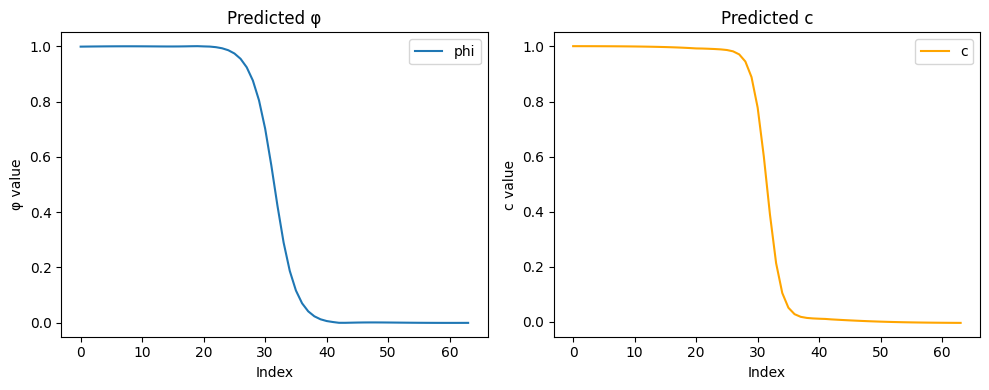

In [6]:
_,_,_,_,_,params_final,_ = final_carry
model_final = eqx.combine(params_final, static)
phi_pred, c_pred  = model_final(x.ic, 0 * jnp.ones_like(x.ic))

# Assuming phi_pred and c_pred are 1D arrays of same length
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(phi_pred, label="phi")
axes[0].set_title("Predicted φ")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("φ value")
axes[0].legend()

axes[1].plot(c_pred, label="c", color="orange")
axes[1].set_title("Predicted c")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("c value")
axes[1].legend()

plt.tight_layout()
plt.show()
